<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/Dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 云盘挂载

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 解压数据

In [0]:
ROOT='gdrive/My Drive/Colab Notebooks/udacity/data'
import os

In [5]:
# 首次执行需要解压缩包
# import zipfile
# extension='.zip'
# for item in os.listdir(ROOT):
#   if item.endswith(extension):
#     file_name=os.path.join(ROOT,item)
#     print(file_name)
#     zip_ref=zipfile.ZipFile(file_name)
#     os.mkdir(file_name.replace('.zip',''))
#     zip_ref.extractall(file_name.replace('.zip',''))
#     zip_ref.close()
#     os.remove(file_name)

gdrive/My Drive/Colab Notebooks/udacity/data/dog_images.zip
gdrive/My Drive/Colab Notebooks/udacity/data/lfw.zip


In [10]:
dog_root=os.path.join(ROOT,'dog_images')
# os.listdir(dog_root)

['dog_images']

In [0]:
lfw_root=os.path.join(ROOT,'lfw')
# os.listdir(lfw_root)

In [18]:
os.chdir(ROOT)

KeyboardInterrupt: ignored

In [189]:
!ls

anna.txt  dog_images  haarcascades  lfw  model_scratch.pt  text8.txt


In [21]:
import numpy as np
from glob import glob
human_files=np.array(glob('lfw/*/*/*'))
dog_files=np.array(glob('dog_images/*/*/*/*'))
print('There are %d total human images.'%len(human_files))
print('There are %d total dog images.'%len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


# 检测人脸

In [190]:
!ls

anna.txt  dog_images  haarcascades  lfw  model_scratch.pt  text8.txt


Nummber of faces detected: 1


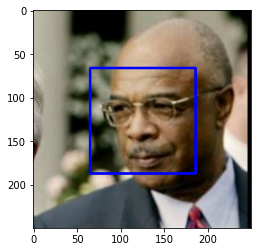

In [195]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

face_cascade=cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img=cv2.imread(human_files[0])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces=face_cascade.detectMultiScale(gray)
print('Nummber of faces detected:',len(faces))

for (x,y,w,h) in faces:
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

cv_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

In [0]:
# human face detector
def face_detector(img_path):
  img=cv2.imread(img_path)
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray)
  return len(faces)>0

In [199]:
from tqdm import tqdm

human_files_short=human_files[:100]
dog_files_short=dog_files[:100]

face_detect_real=0
face_detect_fake=0

for i in tqdm(range(100)):
  face_detect_real+=face_detector(human_files_short[i])
  face_detect_fake+=face_detector(dog_files_short[i])
print()
print('percentage in human_files_short detected face:',face_detect_real/100)
print('percentage in dog_files_short detected face:',face_detect_fake/100)

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


percentage in human_files_short detected face: 0.99
percentage in dog_files_short detected face: 0.18


# 检测狗

In [22]:
import torch
import torchvision.models as models

VGG16=models.vgg16(pretrained=True)
VGG16=VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
# making predictions with a pretrained model
from PIL import Image
import torchvision.transforms as transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

def VGG16_predict(img_path):
  img=Image.open(img_path)
  trans=transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor()
  ])
  image=trans(img).unsqueeze(dim=0)
  image=image.cuda()
  with torch.no_grad():
    out=VGG16(image)
  return out.argmax(dim=1).item()

In [0]:
# write a dog detector
def dog_detector(img_path):
  pred=VGG16_predict(img_path)
  return (pred>=151) and (pred<=268)

In [33]:
# assess the dog detector
from tqdm import tqdm 

dog_detect_real=0
dog_detect_fake=0

for i in tqdm(range(100)):
  dog_detect_real+=int(dog_detector(dog_files_short[i]))
  dog_detect_fake+=int(dog_detector(human_files_short[i]))
print()
print('percentage in human_files_short detected dog:',dog_detect_fake/100)
print('percentage in dog_files_short detected dog:',dog_detect_real/100)

100%|██████████| 100/100 [00:02<00:00, 37.68it/s]


percentage in human_files_short detected dog: 0.0
percentage in dog_files_short detected dog: 0.95


# 从头开始建立CNN模型检测狗品种

In [34]:
!ls

anna.txt  dog_images  lfw  text8.txt


In [0]:
# specify data loader for the dog dataset
from torchvision import datasets
train_folder='./dog_images/dog_images/train'
val_folder='./dog_images/dog_images/valid'
test_folder='./dog_images/dog_images/test'

dog_transform=transforms.Compose([
  transforms.Resize(250),
  transforms.CenterCrop(224),
  transforms.ToTensor()
])

train_dataset=datasets.ImageFolder(train_folder,dog_transform)
valid_dataset=datasets.ImageFolder(val_folder,dog_transform)
test_dataset=datasets.ImageFolder(test_folder,dog_transform)

In [51]:
print('len of train dataset:',len(train_dataset),'\n'
   'len of val dataset:',len(valid_dataset),'\n'
   'len of test dataset:',len(test_dataset))

len of train dataset: 6680 
len of val dataset: 835 
len of test dataset: 836


In [0]:
from torch.utils.data import DataLoader
batch_size=120
train_iter=DataLoader(train_dataset,shuffle=True,batch_size=batch_size,num_workers=4)
valid_iter=DataLoader(valid_dataset,shuffle=True,batch_size=batch_size,num_workers=4)
test_iter=DataLoader(test_dataset,shuffle=True,batch_size=batch_size,num_workers=4)

In [55]:
for X,Y in train_iter:
  print(X.shape,Y.shape)
  break

torch.Size([120, 3, 224, 224]) torch.Size([120])


In [0]:
# model architecture
from torch import nn,optim
import torch.nn.functional as F

def conv_block(in_c,out_c):
  return nn.Sequential(
    nn.Conv2d(in_c,out_c,3,1,1),
    nn.BatchNorm2d(out_c),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
  )
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=conv_block(3,8)  #(n,8,112,112)
    self.conv2=conv_block(8,16)  #(n,16,56,56)
    self.conv3=conv_block(16,16) #(n,16,28,28)
    self.conv4=conv_block(16,32) #(n,32,14,14)
    self.conv5=conv_block(32,64) #(n,64,7,7)
    self.drop1=nn.Dropout(0.5)
    self.fc1=nn.Linear(64*7*7,1024)
    self.drop2=nn.Dropout(0.3)
    self.fc2=nn.Linear(1024,512)
    self.fc3=nn.Linear(512,133)
  def forward(self,x):
    # x:(n,3,224,224)
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=x.view(x.shape[0],-1)
    x=self.drop1(x)
    x=self.fc1(x)
    x=self.drop2(x)
    x=self.fc2(x)
    out=self.fc3(x)
    return out

In [183]:
model_scratch=Net()
model_scratch.cuda()

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps

In [0]:
# 训练
def train(model,num_epochs,lr,train_iter,valid_iter):
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr=lr)
  valid_loss_min=np.inf

  for epoch in range(num_epochs):
    train_loss,valid_loss,train_acc,n,count=0.0,0.0,0.0,0,0
    for X,Y in train_iter:
      count+=1
      X=X.cuda()
      Y=Y.cuda()
      y_pred=model(X)  #(n,133)
      loss=criterion(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()
      train_acc+=(y_pred.argmax(dim=1)==Y).sum().item()
      n+=Y.shape[0]
      if count%5==0:
        print('Epoch:{} | Valid:{}/{} | Training loss:{:.3f} | Train acc:{:.3f}'.\
            format(epoch+1,count,len(train_iter),loss.item(),train_acc/n))
    print('ok....')
    model.eval()
    for X,Y in valid_iter:
      X=X.cuda()
      Y=Y.cuda()
      with torch.no_grad():
        y_pred=model(X)
        loss=criterion(y_pred,Y)
        valid_loss+=loss.item()
    model.train()
    train_loss=train_loss/len(train_iter)
    valid_loss=valid_loss/len(valid_iter)
    if valid_loss<valid_loss_min:
      valid_loss_min=valid_loss
      torch.save(model.state_dict(),'model_scratch.pt')
    
    print('Epoch:{} | Training loss:{:.3f} | Valid loss:{:.3f}'.\
          format(epoch+1,train_loss,valid_loss))
    print()


In [185]:
num_epochs,lr=1,0.001  # 速度太慢，只做一个epoch
train(model_scratch,num_epochs,lr,train_iter,valid_iter)

Epoch:1 | Valid:5/56 | Training loss:5.606 | Train acc:0.007
Epoch:1 | Valid:10/56 | Training loss:5.895 | Train acc:0.009
Epoch:1 | Valid:15/56 | Training loss:5.392 | Train acc:0.014
Epoch:1 | Valid:20/56 | Training loss:5.169 | Train acc:0.014
Epoch:1 | Valid:25/56 | Training loss:5.021 | Train acc:0.018
Epoch:1 | Valid:30/56 | Training loss:4.993 | Train acc:0.020
Epoch:1 | Valid:35/56 | Training loss:4.764 | Train acc:0.025
Epoch:1 | Valid:40/56 | Training loss:4.967 | Train acc:0.025
Epoch:1 | Valid:45/56 | Training loss:4.551 | Train acc:0.027
Epoch:1 | Valid:50/56 | Training loss:4.587 | Train acc:0.028
Epoch:1 | Valid:55/56 | Training loss:4.488 | Train acc:0.029
ok....
Epoch:1 | Training loss:5.004 | Valid loss:4.521



In [0]:
# 测试
def test(model,test_iter):
  acc,n=0.0,0
  model.eval()
  with torch.no_grad():
    for X,Y in tqdm(test_iter):
      X=X.cuda()
      Y=Y.cuda()
      y_pred=model(X)
      acc+=(y_pred.argmax(dim=1)==Y).sum().item()
      n+=Y.shape[0]
  return acc/n

In [187]:
test(model_scratch,test_iter)

100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


0.03827751196172249

# 迁移学习狗品种分类

In [0]:
model_transfer=models.resnet50(pretrained=True)

In [0]:
model_transfer.fc=nn.Linear(2048,133)

In [0]:
for name,layer in model_transfer._modules.items():
  if name!='fc':
    for param in layer.parameters():
      param.requires_grad=False

In [143]:
for param in model_transfer.fc.parameters():
  print(param.requires_grad)

True
True


In [0]:
model_transfer=model_transfer.cuda()

In [145]:
num_epochs,lr=3,0.003
train(model_transfer,num_epochs,lr,train_iter,valid_iter)

Epoch:1 | Valid:5/56 | Training loss:4.840 | Train acc:0.080
Epoch:1 | Valid:10/56 | Training loss:3.394 | Train acc:0.181
Epoch:1 | Valid:15/56 | Training loss:2.638 | Train acc:0.237
Epoch:1 | Valid:20/56 | Training loss:2.016 | Train acc:0.299
Epoch:1 | Valid:25/56 | Training loss:1.455 | Train acc:0.361
Epoch:1 | Valid:30/56 | Training loss:1.045 | Train acc:0.410
Epoch:1 | Valid:35/56 | Training loss:0.892 | Train acc:0.454
Epoch:1 | Valid:40/56 | Training loss:0.930 | Train acc:0.491
Epoch:1 | Valid:45/56 | Training loss:0.882 | Train acc:0.522
Epoch:1 | Valid:50/56 | Training loss:0.749 | Train acc:0.551
Epoch:1 | Valid:55/56 | Training loss:0.815 | Train acc:0.571
ok....
Epoch:1 | Training loss:1.919 | Valid loss:0.733

Epoch:2 | Valid:5/56 | Training loss:0.418 | Train acc:0.848
Epoch:2 | Valid:10/56 | Training loss:0.448 | Train acc:0.868
Epoch:2 | Valid:15/56 | Training loss:0.504 | Train acc:0.864
Epoch:2 | Valid:20/56 | Training loss:0.376 | Train acc:0.865
Epoch:2 | Valid

In [146]:
# test the model
test(model_transfer,test_iter)

0.8313397129186603

In [0]:
# predict dog breed with the model
class_names=train_dataset.classes

In [152]:
name_list=[]
for num_name in class_names:
  name=num_name.split('.')[1]
  name_list.append(name)
print(len(name_list))
print(name_list)

133
['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute', 'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier', 'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog', 'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle', 'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois', 'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise', 'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres', 'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier', 'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso', 'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever', 'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel', 'Cocker_spaniel', 'Coll

In [0]:
def predict(model,name_list,img_path):
  img=Image.open(img_path)
  trans=transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor()
  ])
  image=trans(img).unsqueeze(dim=0)
  image=image.cuda()
  with torch.no_grad():
    out=model(image)
  idx=out.argmax(dim=1).item()
  clas=name_list[idx]
  return clas

In [181]:
import matplotlib.pyplot as plt

index=400
img_path=dog_files[index]

pred_clas=predict(model_transfer,name_list,img_path)
real_clas=img_path.split('.')[1].split('/')[0]

print('pred:',pred_clas)
print('real:',real_clas)

pred: Dachshund
real: Dachshund


# detect app

In [0]:
def run_app(img_path):
  # 如果检测到狗，则返回预测的种类
  # 如果监测到人，则返回最接近的狗的种类
  # 未检测到人或者狗，则输出错误信息
  img=Image.open(img_path)
  np_img=np.array(img)
  plt.figure()
  plt.imshow(np_img)

  if dog_detector(img_path):
    clas=predict(model_transfer,name_list,img_path)
    plt.title('hello,dog! your breed is {}'.format(clas))
  elif face_detector(img_path):
    clas=predict(model_transfer,name_list,img_path)
    plt.title('hello,human! You look like a...\n {}'.format(clas))
  else:
    plt.title('error!')

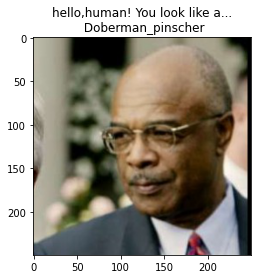

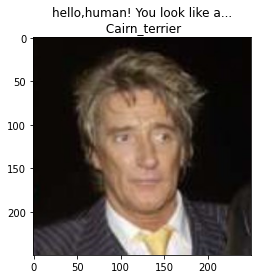

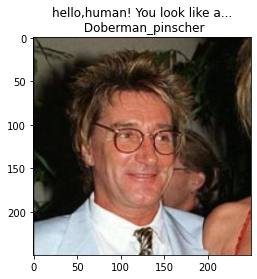

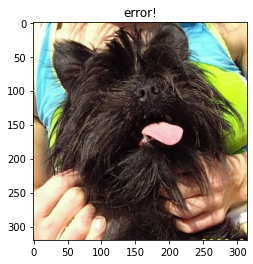

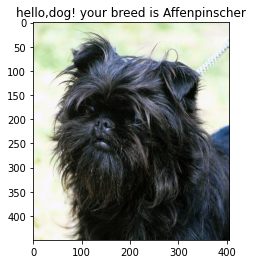

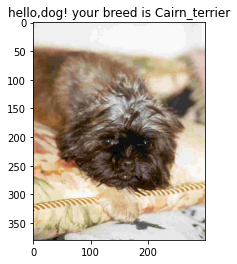

In [208]:
for file in np.hstack((human_files[:3],dog_files[:3])):
  run_app(file)